# This notebook is to study purity/stability of tau12 and tau31, which are chosen for cross-closure test, to decide the chosen binnings of them.

In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1.172e5,7.76e3,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626,3.205e8])
EventNumber=np.array([6730737.00,4150588.00,3815049.25,3371704.00,2008088.12,1156036.00,174078.00,154791.00,154929.00,125457.00,248842.97])
#CrossSection=3.205e8
#EventNumber=248842.97
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=['QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf','QCD Herwigg++']
print len(Scale),len(MC_Compo)
#MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[6.25149133e+02 6.71229040e+01 6.04256267e+00 1.97946848e+00
 5.73012254e-01 2.90840623e-01 1.73201091e-01 2.60698930e-02
 1.56465416e-03 4.65312035e-05 4.62403700e+07]
11 11


In [3]:
fData=[]
path='/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_JetHT2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt170to300.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt300to470.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt470to600.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt600to800.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt800to1000.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1000to1400.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1400to1800.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1800to2400.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt2400to3200.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt3200toInf.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Herwigpp.root'
]
print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,MC_fake,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    tunfolderData.SubtractBackground(MC_fake,"fake",1.)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_1^{(2)}$

In [7]:
reco='recoJet1_tau_2_1_nom_dijetSel'
fake='fakerecoJet1_tau_2_1_dijetSel'
gen='genJet1_tau_2_1_dijetSel'
miss='miss'+gen
response='respJet1_tau_2_1_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC3_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC3_fake0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC3_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response3 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


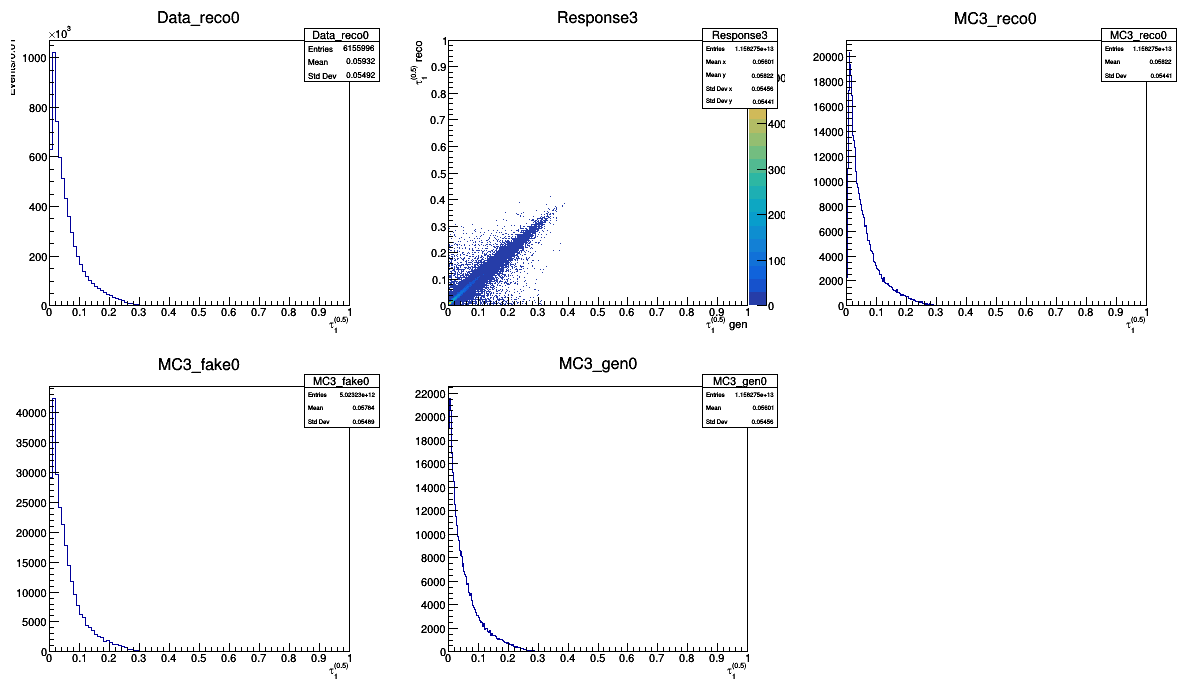

In [16]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
#MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
#MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
#Response1_0=rt.TH2D("Response1","Response1;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",100,0,1,100,0,1)
#MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
#MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
#Response2_0=rt.TH2D("Response2","Response2;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",100,0,1,100,0,1)
MC3_reco0=rt.TH1D("MC3_reco0","MC3_reco0;#tau_{1}^{(0.5)};Events/0.01",400,0,1)
MC3_fake0=rt.TH1D("MC3_fake0","MC3_fake0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
#MC3_gen0=rt.TH1D("MC3_gen0","MC3_gen0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
MC3_gen0=rt.TH1D("MC3_gen0","MC3_gen0;#tau_{1}^{(0.5)};Events/0.01",400,0,1)
Response3_0=rt.TH2D("Response3","Response3;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",400,0,1,400,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    Data_reco0.Add(t.Get(fake))
    f_Data[i].Close()

#f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
#i=0
f_MC=rt.TFile.Open(fMC[len(fMC)-1],'read')
t=f_MC.Get('jetObservables')
MC3_reco0.Add(t.Get(response).ProjectionY(),Scale[len(fMC)-1])
#MC3_reco0.Add(t.Get(reco),Scale[len(fMC)-1])
MC3_fake0.Add(t.Get(fake),Scale[len(fMC)-1])
MC3_gen0.Add(t.Get(response).ProjectionX(),Scale[len(fMC)-1])
#MC3_gen0.Add(t.Get(gen),Scale[len(fMC)-1])
Response3_0.Add(t.Get(response),Scale[len(fMC)-1])
f_MC.Close()
'''
for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()
'''
c0=rt.TCanvas("c0","c0",0,0,1200,720)
c0.Divide(3,2)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(3)
MC3_reco0.Draw("hist")
c0.cd(4)
MC3_fake0.Draw("hist")
c0.cd(2)
Response3_0.Draw("Colz")
c0.cd(5)
MC3_gen0.Draw("hist")
c0.Draw()

In [17]:
for i in range(MC3_reco0.GetNbinsX()):
    print Response3_0.ProjectionX().GetBinCenter(i+1),MC3_gen0.GetBinContent(i+1),MC3_reco0.GetBinContent(i+1)

0.00125 7477.93713314 2269.92489245
0.00375 19056.8998076 11053.8587156
0.00625 21535.4160809 17293.8640824
0.00875 20562.9069048 20303.0487362
0.01125 19041.2785853 19338.1926284
0.01375 16903.3342936 18501.0877744
0.01625 15271.5307359 16908.4659742
0.01875 14471.1298214 14938.0810746
0.02125 13023.0653565 13695.5546286
0.02375 12561.6292135 13234.4874358
0.02625 11484.3025639 12676.5064553
0.02875 10727.0502213 11181.9403167
0.03125 10265.8580613 10804.6838503
0.03375 9817.95804951 9849.20688196
0.03625 9461.40249671 9493.68210508
0.03875 8659.5250535 9435.82991389
0.04125 8199.21635989 9039.20786224
0.04375 8554.48988783 8543.07139598
0.04625 8115.74425763 8119.4865351
0.04875 7271.55107327 7923.15972926
0.05125 7526.34002512 7615.02463869
0.05375 6879.16874414 7306.50149884
0.05625 6619.41036967 7124.13745735
0.05875 6393.660312 7058.59115477
0.06125 6383.78225254 6371.66539591
0.06375 5699.29418837 6434.20851325
0.06625 5826.08340864 5835.40604926
0.06875 5035.71406377 5633.79208

# Different bins

In [18]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.35,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.37,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=21,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.36,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=14,start=0.02,stop=0.28)])
gen_bins1=np.concatenate((np.array([0.]),gen_bins1,np.array([0.31,0.34,0.46])))
reco_bins1=np.array([x for x in np.linspace(num=27,start=0.02,stop=0.28)])
reco_bins1=np.concatenate((np.array([0.,0.01]),reco_bins1,np.array([0.295,0.31,0.325,0.34,0.4,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)


Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.08 0.16 0.24 0.46] 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.35 0.46] 8
[0.   0.06 0.12 0.18 0.24 0.3  0.46] 6
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.37 0.46] 12
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.46] 11
[0.    0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165
 0.18  0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.36  0.46 ] 22
0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.46
0.0,0.015,0.03,0.045,0.06,0.075,0.09,0.105,0.12,0.135,0.15,0.16499999999999998,0.18,0.195,0.21,0.22499999999999998,0.24,0.255,0.27,0.285,0.3,0.36,0.46
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.31 0.34 0.46] 17
[0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
 0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
 0.24  0.25  0.26  0.27  0.28  0.295 0.31  0.325 0.34  0.4   0.46 ] 34


In [19]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{1}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC3_reco=rt.TH1D("MC_reco Herwigg++","MC_reco Herwigg++;#tau_{1}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC3_fake=rt.TH1D("MC_fake Herwigg++","MC_fake Herwigg++;#tau_{1}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC3_gen=rt.TH1D("MC_gen Herwigg++","MC_gen Herwigg++;#tau_{1}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response3=rt.TH2D("Response Matrix Herwigg++","Response Matrix Herwigg++;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC3_reco0,MC3_reco,reco_bin)
    Fill1D(MC3_gen0,MC3_gen,gen_bin)
    Fill1D(MC3_fake0,MC3_fake,reco_bin)
    Fill2D(Response3_0,Response3,gen_bin,reco_bin)

    Response3.SetTitle("Response Matrix #tau_{1}^{(2)} binning %d"%(i+1))
    Response3.SetStats(0)
    responses.append(Response3)
    
    purity,stability=PurityStability(Response3_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    #Data_reco.Scale(1.0/Data_reco.Integral())
    K=9.03839042139
    MC3_reco.Scale(K)
    MC3_fake.Scale(K)
    MC3_gen.Scale(K)
    
    hs,ratio,leg=DoUnfolding(Response3,Data_reco,MC3_reco,MC3_gen,MC3_fake,"#tau_{1}^{(2)}","Herwigg++",gen_bin)
    
    hs.SetTitle("#tau_{1}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.08 0.16 0.24 0.46]
for binning 2
[0.   0.06 0.12 0.18 0.24 0.3  0.46]
for binning 3
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.46]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.31 0.34 0.46]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_fake Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{

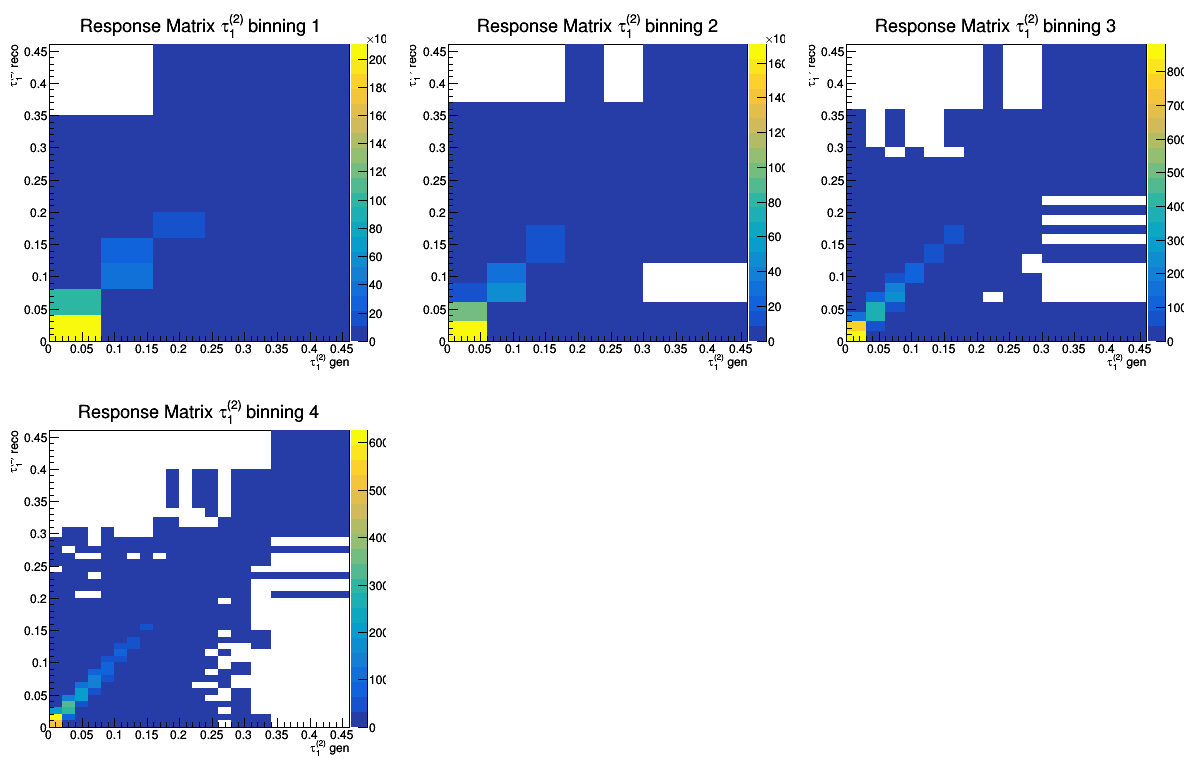

In [20]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


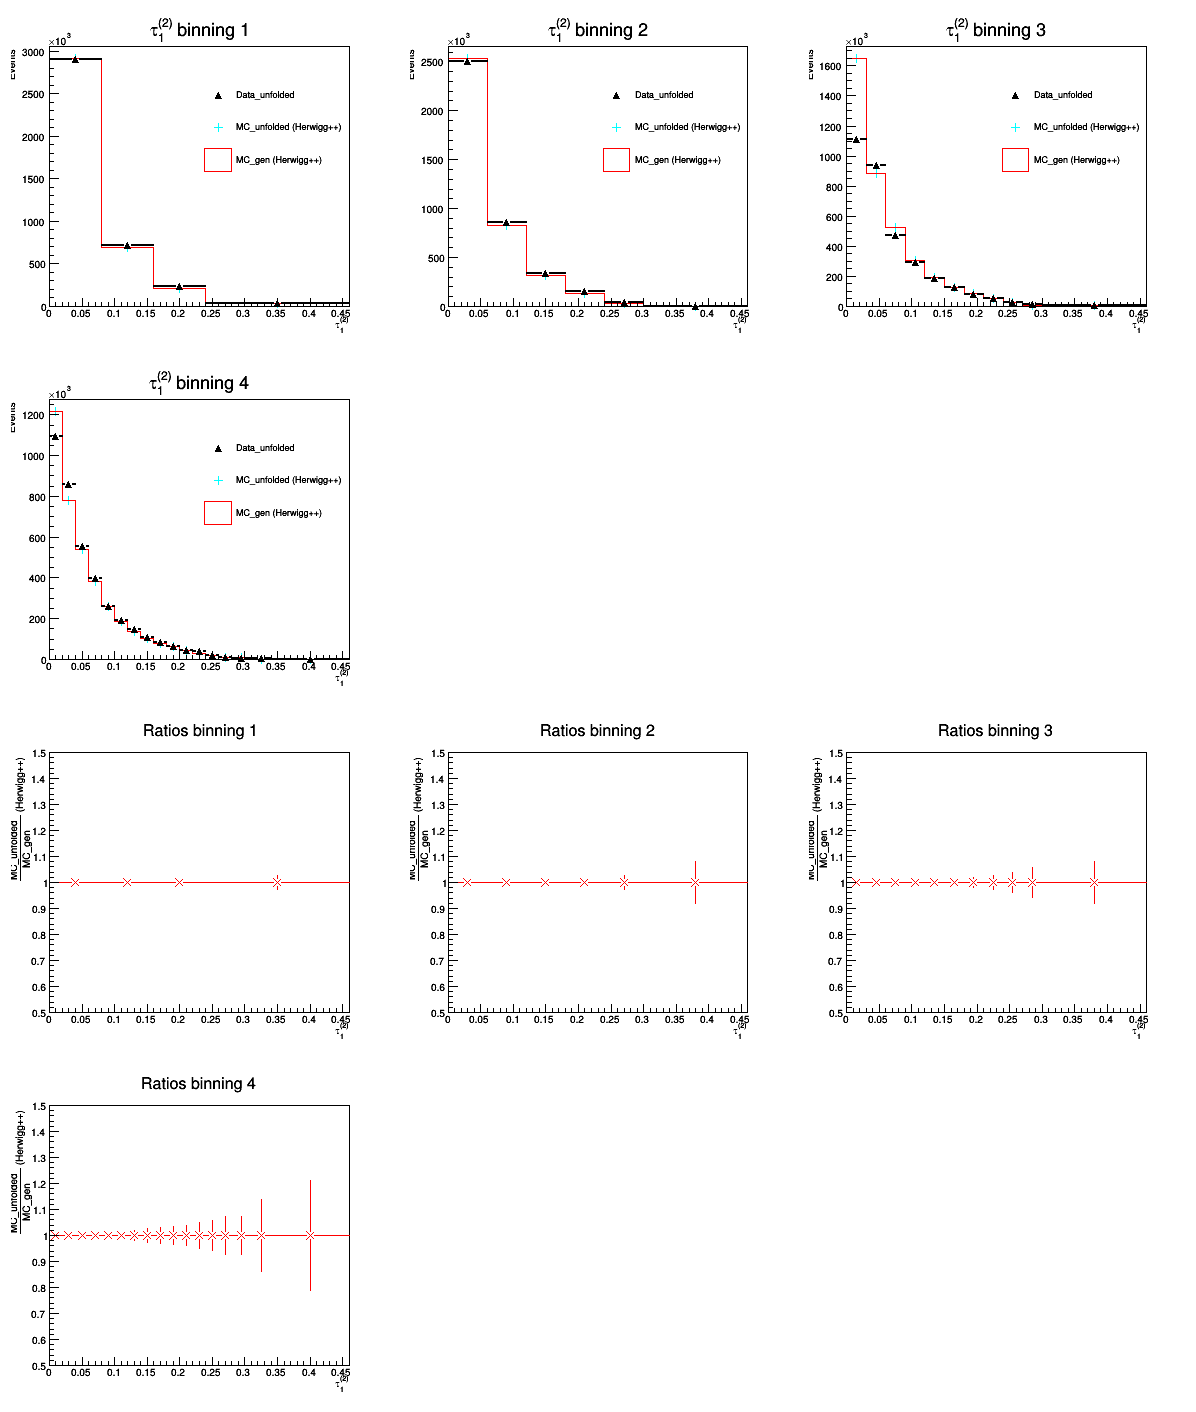

In [21]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{1}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

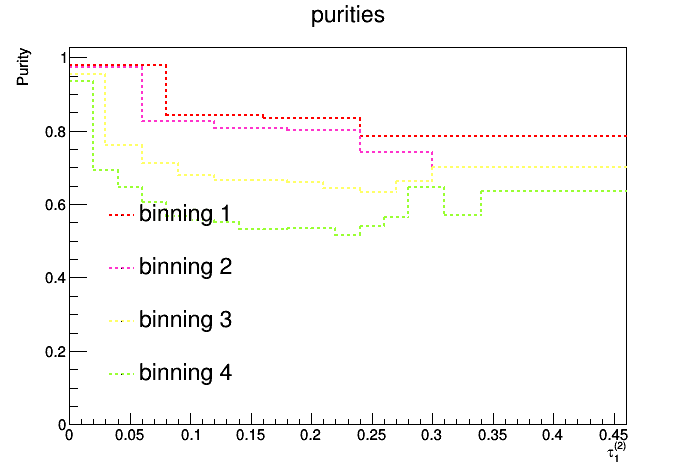

In [22]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{1}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

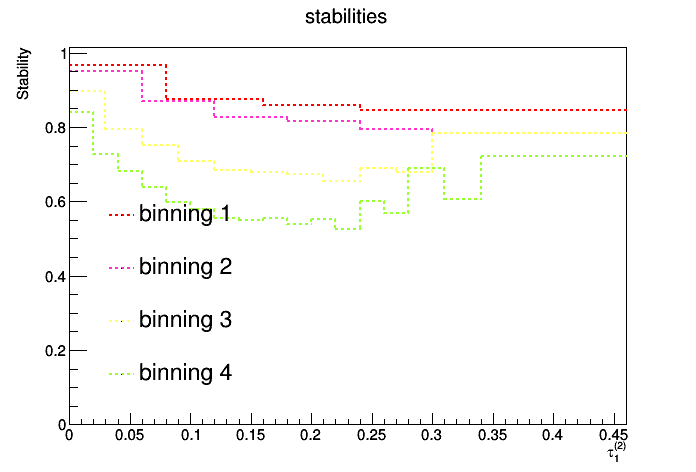

In [23]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{1}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

# $\tau_{3}^{(1)}$

In [7]:
reco='recoJet1_tau_1_3_nom_dijetSel'
fake='fakerecoJet1_tau_1_3_dijetSel'
gen='genJet1_tau_1_3_dijetSel'
miss='miss'+gen
response='respJet1_tau_1_3_nom_dijetSel'

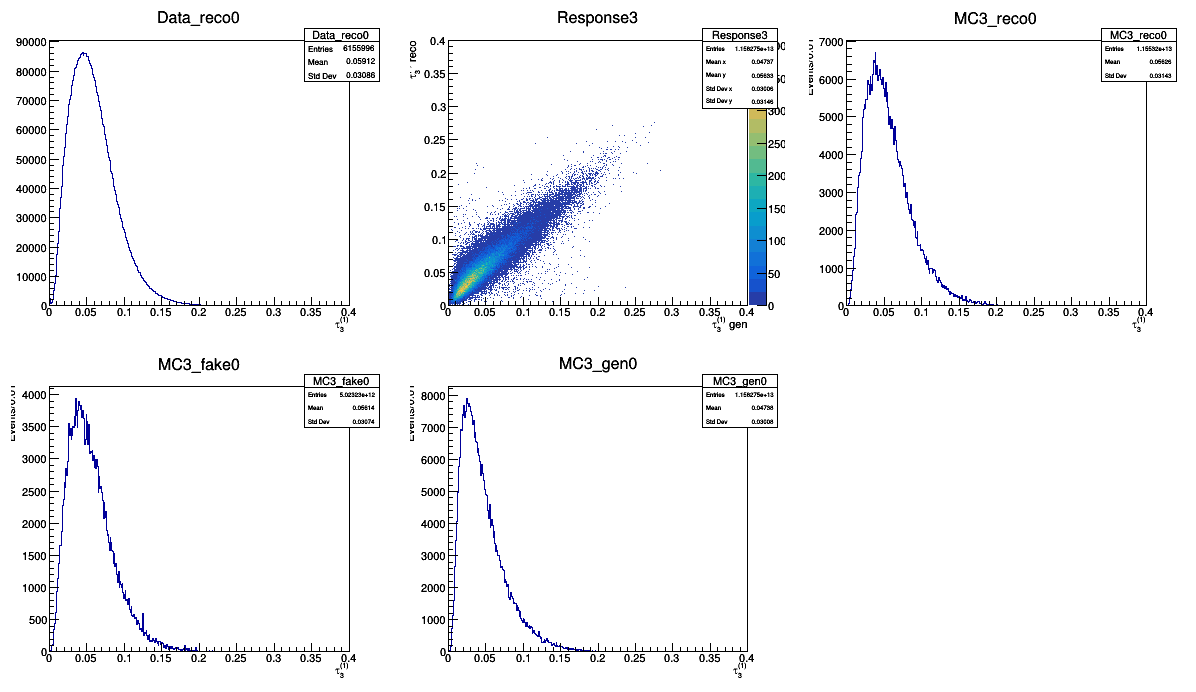

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
#MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
#MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
#Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",100,0,1,100,0,1)
#MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
#MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
#Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",100,0,1,100,0,1)
MC3_reco0=rt.TH1D("MC3_reco0","MC3_reco0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
MC3_fake0=rt.TH1D("MC3_fake0","MC3_fake0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
#MC3_gen0=rt.TH1D("MC3_gen0","MC3_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC3_gen0=rt.TH1D("MC3_gen0","MC3_gen0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
Response3_0=rt.TH2D("Response3","Response3;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",400,0,0.4,400,0,0.4)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    Data_reco0.Add(t.Get(fake))
    f_Data[i].Close()

#f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
#i=0
f_MC=rt.TFile.Open(fMC[len(fMC)-1],'read')
t=f_MC.Get('jetObservables')
#MC3_reco0.Add(t.Get(response).ProjectionY(),Scale[len(fMC)-1])
MC3_reco0.Add(t.Get(reco),Scale[len(fMC)-1])
MC3_fake0.Add(t.Get(fake),Scale[len(fMC)-1])
#MC3_gen0.Add(t.Get(response).ProjectionX(),Scale[len(fMC)-1])
MC3_gen0.Add(t.Get(gen),Scale[len(fMC)-1])
Response3_0.Add(t.Get(response),Scale[len(fMC)-1])
f_MC.Close()
'''
for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()
'''
c0=rt.TCanvas("c0","c0",0,0,1200,720)
c0.Divide(3,2)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(3)
MC3_reco0.Draw("hist")
c0.cd(4)
MC3_fake0.Draw("hist")
c0.cd(2)
Response3_0.Draw("Colz")
c0.cd(5)
MC3_gen0.Draw("hist")
c0.Draw()

In [9]:
print MC3_reco0.GetNbinsX()
for i in range(MC3_reco0.GetNbinsX()):
    print Response3_0.ProjectionX().GetBinCenter(i+1),Response3_0.ProjectionX().GetBinContent(i+1),Response3_0.ProjectionY().GetBinContent(i+1)

400
0.0005 0.0 22.3515293341
0.0015 4.15849535326 6.26793670187
0.0025 53.516481438 67.7205112534
0.0035 162.676839948 141.715965169
0.0045 301.780543303 235.018092527
0.0055 715.835660025 436.237778333
0.0065 1136.56679705 671.094718835
0.0075 1597.83838082 812.925946339
0.0085 2301.9434114 928.086228261
0.0095 2690.6082465 1296.70513378
0.0105 3452.90465571 1523.02394394
0.0115 4097.55497449 2086.20380804
0.0125 4787.30481424 2410.48805043
0.0135 4948.89600725 2493.07296687
0.0145 5865.33621637 3131.64698074
0.0155 6175.41551864 3333.33398905
0.0165 6269.95071502 3459.24816851
0.0175 7002.27655132 3536.07067689
0.0185 6932.18727659 3915.67522128
0.0195 7348.55252952 4068.88459758
0.0205 7428.95826725 4106.2322498
0.0215 7718.2891921 4978.95450343
0.0225 7327.92807887 5211.03420833
0.0235 7549.82036702 5340.93705462
0.0245 7586.71127549 5263.95996926
0.0255 7888.59955434 5464.69485646
0.0265 7784.94433594 5478.15948143
0.0275 7664.5913035 5772.42718343
0.0285 7856.53739235 5985.128280

0.2965 0.0 0.0
0.2975 0.0 0.0
0.2985 0.0 0.0
0.2995 0.0 0.0
0.3005 0.0 0.0
0.3015 0.0 0.0
0.3025 0.0 0.0
0.3035 0.0 0.0
0.3045 0.0 0.0
0.3055 0.0 0.0
0.3065 0.0 0.0
0.3075 0.0 0.0
0.3085 0.0 0.0
0.3095 0.0 0.0
0.3105 0.0 0.0
0.3115 0.0 0.0
0.3125 0.0 0.0
0.3135 0.0 0.0
0.3145 0.0 0.0
0.3155 0.0 0.0
0.3165 0.0 0.0
0.3175 0.0 0.0
0.3185 0.0 0.0
0.3195 0.0 0.0
0.3205 0.0 0.0
0.3215 0.0 0.0
0.3225 0.0 0.0
0.3235 0.0 0.0
0.3245 0.0 0.0
0.3255 0.0 0.0
0.3265 0.0 0.0
0.3275 0.0 0.0
0.3285 0.0 0.0
0.3295 0.0 0.0
0.3305 0.0 0.0
0.3315 0.0 0.0
0.3325 0.0 0.0
0.3335 0.0 0.0
0.3345 0.0 0.0
0.3355 0.0 0.0
0.3365 0.0 0.0
0.3375 0.0 0.0
0.3385 0.0 0.0
0.3395 0.0 0.0
0.3405 0.0 0.0
0.3415 0.0 0.0
0.3425 0.0 0.0
0.3435 0.0 0.0
0.3445 0.0 0.0
0.3455 0.0 0.0
0.3465 0.0 0.0
0.3475 0.0 0.0
0.3485 0.0 0.0
0.3495 0.0 0.0
0.3505 0.0 0.0
0.3515 0.0 0.0
0.3525 0.0 0.0
0.3535 0.0 0.0
0.3545 0.0 0.0
0.3555 0.0 0.0
0.3565 0.0 0.0
0.3575 0.0 0.0
0.3585 0.0 0.0
0.3595 0.0 0.0
0.3605 0.0 0.0
0.3615 0.0 0.0
0.3625 0.0

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=8,start=0.,stop=0.224)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.3])))
reco_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.224)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.25,0.3])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=12,start=0.,stop=0.286)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.3])))
reco_bins1=np.array([x for x in np.linspace(num=23,start=0.,stop=0.286)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.293,0.3])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=14,start=0.,stop=0.286)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.3])))
reco_bins1=np.array([x for x in np.linspace(num=27,start=0.,stop=0.286)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.293,0.3])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=16,start=0.,stop=0.3)])
#gen_bins1=np.concatenate((gen_bins1,np.array([0.66])))
reco_bins1=np.array([x for x in np.linspace(num=31,start=0.,stop=0.3)])
#reco_bins1=np.concatenate((reco_bins1,np.array([0.57,0.66])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)


gen_bins1=np.array([x for x in np.linspace(num=31,start=0.,stop=0.3)])
#gen_bins1=np.concatenate((gen_bins1,np.array([0.3])))
reco_bins1=np.array([x for x in np.linspace(num=61,start=0.,stop=0.3)])
#reco_bins1=np.concatenate((reco_bins1,np.array([0.57,0.3])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
#print(",".join(str(i) for i in gen_bins1))
#print(",".join(str(i) for i in reco_bins1))

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.    0.032 0.064 0.096 0.128 0.16  0.192 0.224 0.3  ] 8
[0.    0.016 0.032 0.048 0.064 0.08  0.096 0.112 0.128 0.144 0.16  0.176
 0.192 0.208 0.224 0.25  0.3  ] 16
0.0,0.032,0.064,0.096,0.128,0.16,0.192,0.224,0.3
0.0,0.016,0.032,0.048,0.064,0.08,0.096,0.112,0.128,0.14400000000000002,0.16,0.176,0.192,0.20800000000000002,0.224,0.25,0.3
[0.    0.026 0.052 0.078 0.104 0.13  0.156 0.182 0.208 0.234 0.26  0.286
 0.3  ] 12
[0.    0.013 0.026 0.039 0.052 0.065 0.078 0.091 0.104 0.117 0.13  0.143
 0.156 0.169 0.182 0.195 0.208 0.221 0.234 0.247 0.26  0.273 0.286 0.293
 0.3  ] 24
[0.    0.022 0.044 0.066 0.088 0.11  0.132 0.154 0.176 0.198 0.22  0.242
 0.264 0.286 0.3  ] 14
[0.    0.011 0.022 0.033 0.044 0.055 0.066 0.077 0.088 0.099 0.11  0.121
 0.132 0.143 0.154 0.165 0.176 0.187 0.198 0.209 0.22  0.231 0.242 0.253
 0.264 0.275 0.286 0.293 0.3  ] 28
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3 ] 15
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.

In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{1}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC3_reco=rt.TH1D("MC_reco Herwigg++","MC_reco Herwigg++;#tau_{1}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC3_fake=rt.TH1D("MC_fake Herwigg++","MC_fake Herwigg++;#tau_{1}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC3_gen=rt.TH1D("MC_gen Herwigg++","MC_gen Herwigg++;#tau_{1}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response3=rt.TH2D("Response Matrix Herwigg++","Response Matrix Herwigg++;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC3_reco0,MC3_reco,reco_bin)
    Fill1D(MC3_gen0,MC3_gen,gen_bin)
    Fill1D(MC3_fake0,MC3_fake,reco_bin)
    Fill2D(Response3_0,Response3,gen_bin,reco_bin)

    Response3.SetTitle("Response Matrix #tau_{3}^{(1)} binning %d"%(i+1))
    Response3.SetStats(0)
    responses.append(Response3)
    
    purity,stability=PurityStability(Response3_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    #Data_reco.Scale(1.0/Data_reco.Integral())
    K=9.03839042139
    MC3_reco.Scale(K)
    MC3_fake.Scale(K)
    MC3_gen.Scale(K)
    
    hs,ratio,leg=DoUnfolding(Response3,Data_reco,MC3_reco,MC3_gen,MC3_fake,"#tau_{3}^{(1)}","Herwigg++",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.    0.032 0.064 0.096 0.128 0.16  0.192 0.224 0.3  ]
for binning 2
[0.    0.026 0.052 0.078 0.104 0.13  0.156 0.182 0.208 0.234 0.26  0.286
 0.3  ]


/cvmfs/cms.cern.ch/slc7_amd64_gcc820/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc820/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


for binning 3
[0.    0.022 0.044 0.066 0.088 0.11  0.132 0.154 0.176 0.198 0.22  0.242
 0.264 0.286 0.3  ]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3 ]
for binning 5
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3 ]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 16 input bins and 8 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9 (xaxis:#tau_{1}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 16 input bins and 8 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9 (xaxis:#tau_{1}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in

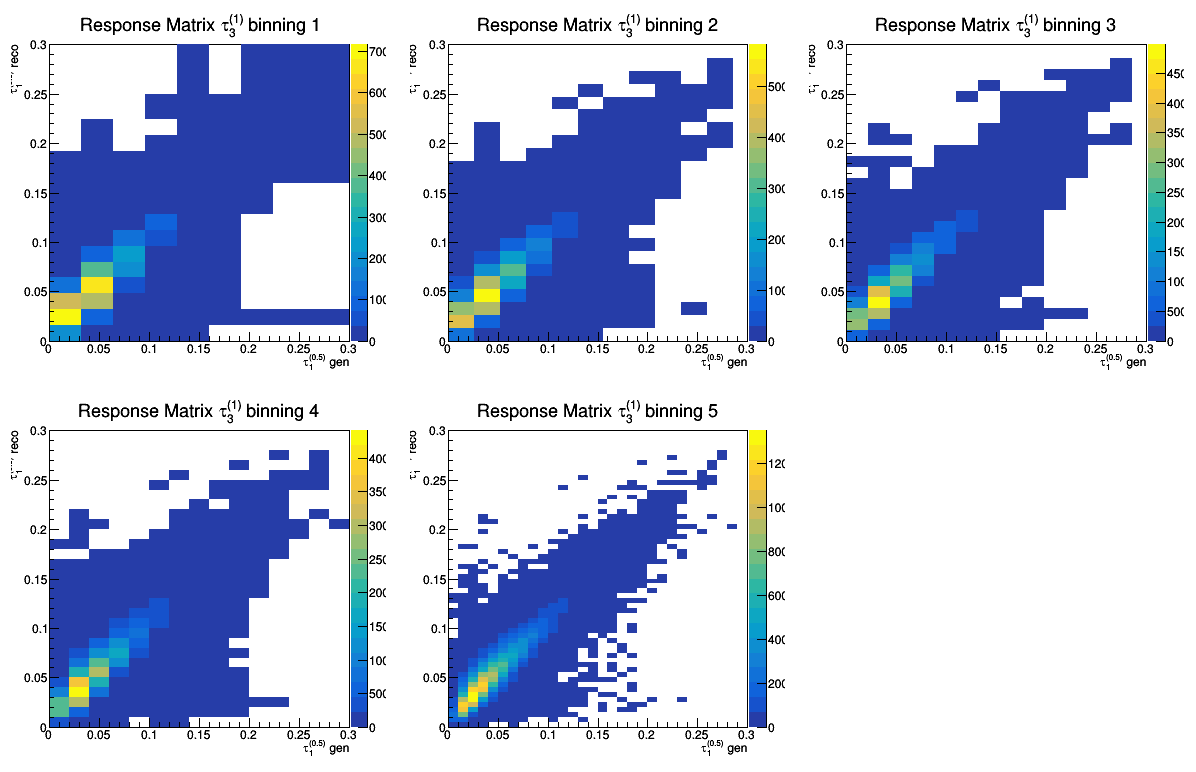

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


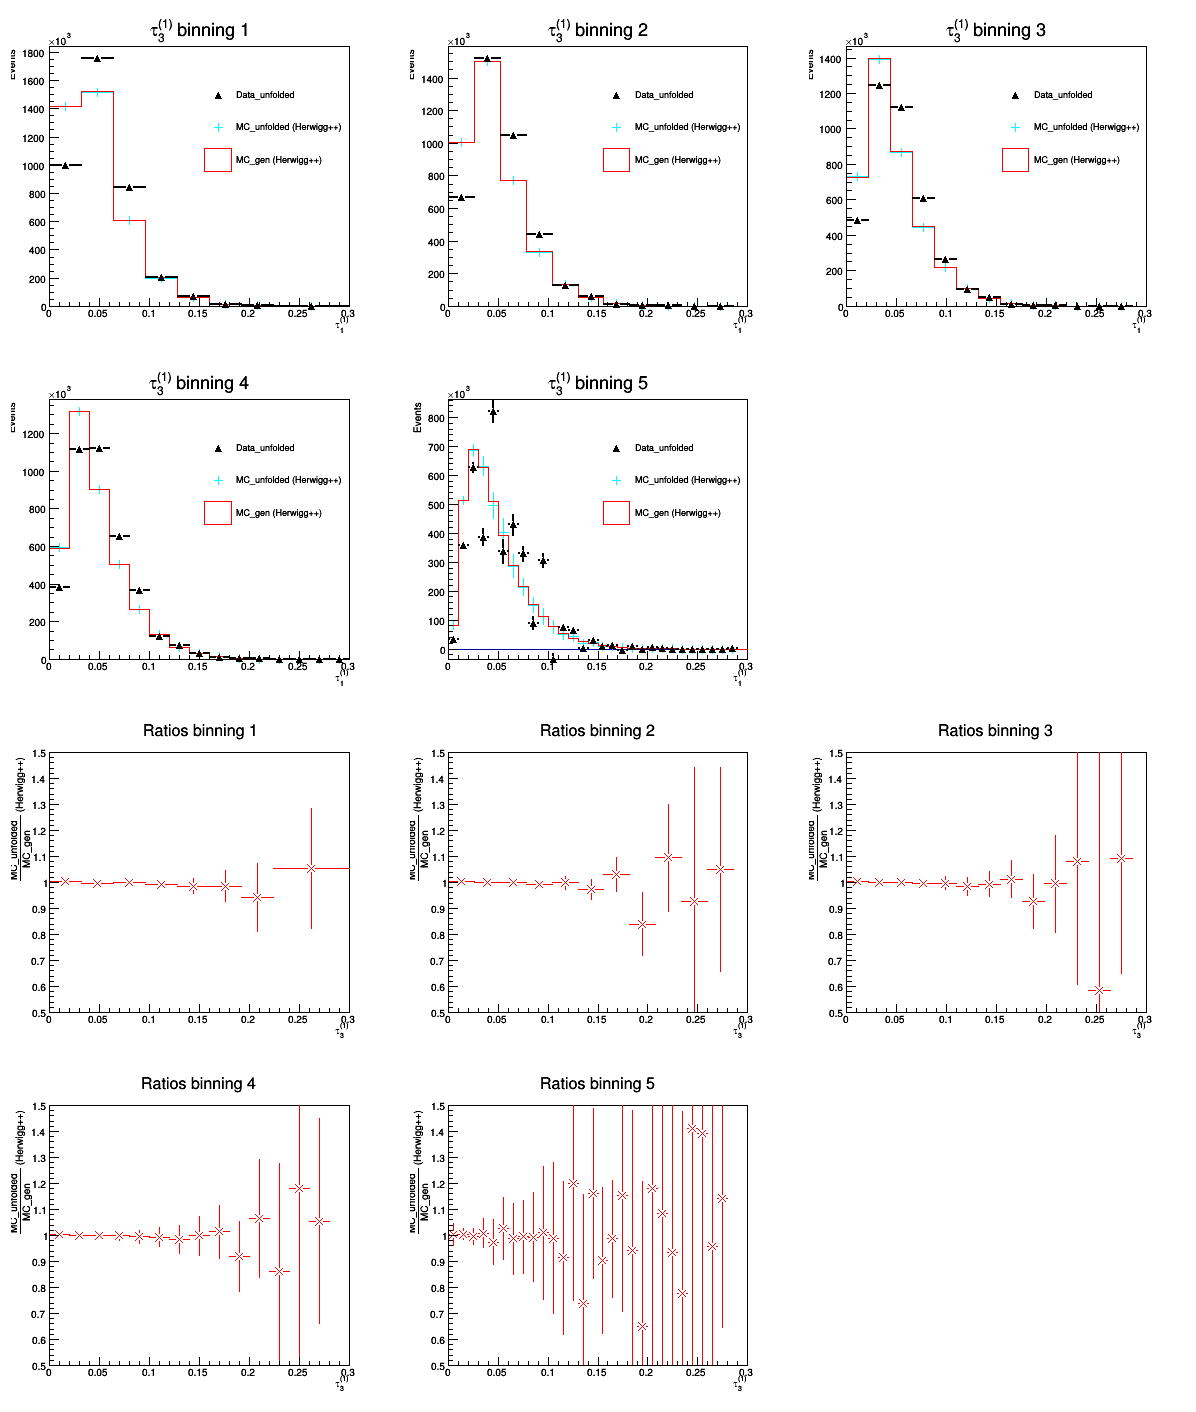

In [13]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{1}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

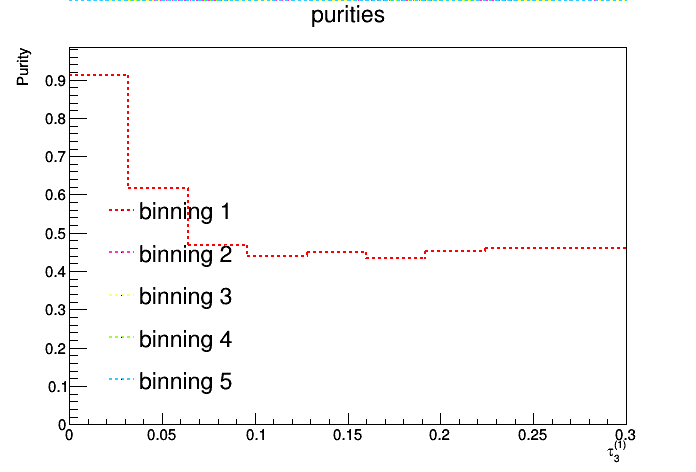

In [14]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

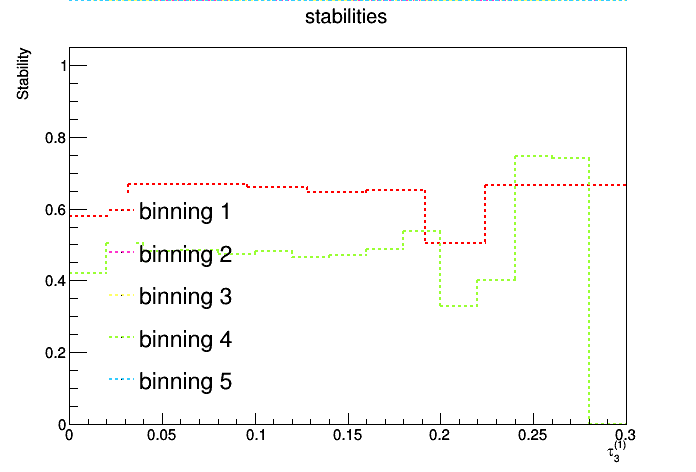

In [15]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()